In [1]:
import pandas as pd
review_data_df = pd.read_json('combined-review-data.json')
review_data_df = review_data_df[review_data_df['rating'] != 3]
review_data_df.head()

,id,alias,coordinates,reviewCount,text,rating
1,DTsMTLeptoad_34f9DFWjQ,starbucks-reserve-chicago-3,"{'latitude': 41.91036, 'longitude': -87.677607}",108,STARBUCKS RESERVE located next to the Blue lin...,5
2,DTsMTLeptoad_34f9DFWjQ,starbucks-reserve-chicago-3,"{'latitude': 41.91036, 'longitude': -87.677607}",108,Got a coffee and told him my name. He abbrevia...,1
3,jFcEuf5B5NmsrLk0sTzpcg,starbucks-chicago-171,"{'latitude': 41.903146, 'longitude': -87.670074}",65,"So here is the scoop. \n\nSubject, customer sa...",5
4,jFcEuf5B5NmsrLk0sTzpcg,starbucks-chicago-171,"{'latitude': 41.903146, 'longitude': -87.670074}",65,I used to love coming here to get some work do...,2
5,jFcEuf5B5NmsrLk0sTzpcg,starbucks-chicago-171,"{'latitude': 41.903146, 'longitude': -87.670074}",65,"This is the busiest Starbucks, I swear!\n\nSer...",4


In [2]:
review_data_df.groupby('rating').count()[['id']]

,id
rating,
1,667
2,199
4,238
5,399


In [3]:
satisfaction_list = []
for rating in review_data_df['rating']:
    if rating > 3:
        satisfaction_list.append('satisfied')
    else:
        satisfaction_list.append('unsatisfied')
        
review_data_df['satisfaction_level'] = satisfaction_list

In [4]:
def should_filter_line(line):
    return line.strip() and line[0] != ';'

In [5]:
positive_lines = []
with open('positive-words.txt', 'r') as pf:
    positive_lines = pf.readlines()
    positive_lines = list(filter(should_filter_line, positive_lines))

for i in range(len(positive_lines)):
    positive_lines[i] = positive_lines[i].replace('\n', '')

In [6]:
negative_lines = []
with open('negative-words.txt', 'r', encoding='utf-8', errors='ignore') as pf:
    negative_lines = pf.readlines()
    negative_lines = list(filter(should_filter_line, negative_lines))

for i in range(len(negative_lines)):
    negative_lines[i] = negative_lines[i].replace('\n', '')

In [7]:
from textblob import TextBlob

num_positive_words_per_row = []
num_negative_words_per_row = []
polarity_values = []
subjectivity_values = []
for review_text in review_data_df['text']:
    pos_counter = 0
    neg_counter = 0
    
    for positive_word in positive_lines:
        if positive_word in review_text:
            pos_counter += 1
    num_positive_words_per_row.append(pos_counter)
    
    for negative_word in negative_lines:
        if negative_word in review_text:
            neg_counter += 1
    num_negative_words_per_row.append(neg_counter)
    
    tb = TextBlob(review_text)
    polarity_values.append(tb.sentiment.polarity)
    subjectivity_values.append(tb.sentiment.subjectivity)

In [8]:
model_df = review_data_df.copy().drop(columns=['id', 'alias', 'coordinates', 'reviewCount', 'text', 'rating'])
model_df['positive_word_count'] = num_positive_words_per_row
model_df['negative_word_count'] = num_negative_words_per_row
model_df['polarity'] = polarity_values
model_df['subjectivity'] = subjectivity_values
model_df = model_df[['positive_word_count', 'negative_word_count', 'polarity', 'subjectivity', 'satisfaction_level']]
model_df.head()

,positive_word_count,negative_word_count,polarity,subjectivity,satisfaction_level
1,2,0,0.100000,0.150000,satisfied
2,0,0,0.000000,0.000000,unsatisfied
3,2,2,0.059524,0.434524,satisfied
4,2,2,0.315000,0.800000,unsatisfied
5,0,6,0.000000,0.000000,satisfied


In [9]:
X = model_df.drop('satisfaction_level', axis=1)
y = model_df['satisfaction_level']
print(X.shape, y.shape)

(1503, 4) (1503,)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [11]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.7622005323868678
Testing Data Score: 0.75


In [14]:
predictions = classifier.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10].tolist()}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   ['satisfied', 'satisfied', 'unsatisfied', 'satisfied', 'satisfied', 'satisfied', 'unsatisfied', 'satisfied', 'unsatisfied', 'unsatisfied']
First 10 Actual labels: ['satisfied', 'unsatisfied', 'unsatisfied', 'satisfied', 'unsatisfied', 'satisfied', 'unsatisfied', 'satisfied', 'unsatisfied', 'unsatisfied']


In [15]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier()
classifier = classifier.fit(X_train, y_train)
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.9893522626441881
Testing Data Score: 0.7074468085106383


In [16]:
predictions = classifier.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10].tolist()}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   ['satisfied', 'unsatisfied', 'unsatisfied', 'satisfied', 'unsatisfied', 'satisfied', 'unsatisfied', 'satisfied', 'unsatisfied', 'satisfied']
First 10 Actual labels: ['satisfied', 'unsatisfied', 'unsatisfied', 'satisfied', 'unsatisfied', 'satisfied', 'unsatisfied', 'satisfied', 'unsatisfied', 'unsatisfied']


In [17]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier = classifier.fit(X_train, y_train)
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.9893522626441881
Testing Data Score: 0.7393617021276596


In [18]:
predictions = classifier.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10].tolist()}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   ['satisfied', 'unsatisfied', 'unsatisfied', 'satisfied', 'satisfied', 'satisfied', 'unsatisfied', 'satisfied', 'unsatisfied', 'unsatisfied']
First 10 Actual labels: ['satisfied', 'unsatisfied', 'unsatisfied', 'satisfied', 'unsatisfied', 'satisfied', 'unsatisfied', 'satisfied', 'unsatisfied', 'unsatisfied']


In [19]:
y = pd.get_dummies(model_df['satisfaction_level'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

k: 1, Train/Test Score: 0.982/0.676
k: 3, Train/Test Score: 0.831/0.705
k: 5, Train/Test Score: 0.817/0.715
k: 7, Train/Test Score: 0.789/0.742
k: 9, Train/Test Score: 0.782/0.734
k: 11, Train/Test Score: 0.776/0.753
k: 13, Train/Test Score: 0.773/0.753
k: 15, Train/Test Score: 0.778/0.747
k: 17, Train/Test Score: 0.778/0.755
k: 19, Train/Test Score: 0.773/0.747


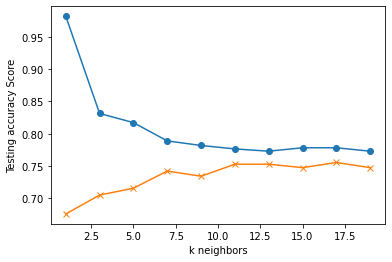

In [21]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [22]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train_scaled, y_train)
print('k=17 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=17 Test Acc: 0.755
